In [5]:
from dataset import ImageDataset, load_dataset, train_val_split, data_augmentation
from model import CNN, CNNWithNAL
import torch
from sklearn.metrics import accuracy_score
import pickle

torch.cuda.empty_cache()

# CIFAR
## Load dataset

In [6]:
training_data, training_labels, testing_data, testing_labels = load_dataset('datasets/CIFAR.npz')

## Preprocessing

In [7]:
training_subset, training_sub_labels, validation_subset, validation_sub_labels = train_val_split(training_data, training_labels)
aug_training, aug_labels = data_augmentation(training_subset, training_sub_labels)

train_dataset = ImageDataset(aug_training, aug_labels)
val_dataset = ImageDataset(validation_subset, validation_sub_labels)
test_dataset = ImageDataset(testing_data, testing_labels)

## CNN Training

In [8]:
import os
prediction_results = []
accuracy_results = []
T_hats = []
for round in range(10):
    print(f"----------Training CNN round {round+1}/10----------")
    cnn = CNN(num_classes=3, dataset_name="CIFAR")
    cnn.train(train_dataset, val_dataset)
    y_true, y_pred = cnn.predict(test_dataset)
    prediction_results.append((y_true, y_pred))
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_results.append(accuracy)
    T_hats.append(train_dataset.transition_matrix)
    # reset transition matrix
    train_dataset.transition_matrix = None
    val_dataset.transition_matrix = None
    print(f"CNN Test Acc: {accuracy*100:.2f}%")

with open('results/cnn_CIFAR_pred_results.pkl', 'wb') as f:
    pickle.dump(prediction_results, f)

with open('results/cnn_CIFAR_acc_results.pkl', 'wb') as f:
    pickle.dump(accuracy_results, f)

with open('results/cnn_CIFAR_transition_matrices.pkl', 'wb') as f:
    pickle.dump(T_hats, f)

----------Training CNN round 1/10----------
Training noisy CNN to estimate transition matrix...
Epoch [1/100], Training Loss: 1.1102, Validation Loss: 1.0955, Validation Accuracy: 35.53%
Epoch [2/100], Training Loss: 1.0972, Validation Loss: 1.1030, Validation Accuracy: 35.13%
Epoch [3/100], Training Loss: 1.0895, Validation Loss: 1.0917, Validation Accuracy: 38.87%
Epoch [4/100], Training Loss: 1.0849, Validation Loss: 1.0983, Validation Accuracy: 36.23%
Epoch [5/100], Training Loss: 1.0759, Validation Loss: 1.1012, Validation Accuracy: 38.47%
Epoch [6/100], Training Loss: 1.0636, Validation Loss: 1.1110, Validation Accuracy: 37.17%
Epoch [7/100], Training Loss: 1.0392, Validation Loss: 1.1279, Validation Accuracy: 37.73%
Epoch [8/100], Training Loss: 0.9881, Validation Loss: 1.2396, Validation Accuracy: 37.23%
Epoch [9/100], Training Loss: 0.8668, Validation Loss: 1.4407, Validation Accuracy: 36.30%
Epoch [10/100], Training Loss: 0.6600, Validation Loss: 2.0354, Validation Accuracy: 

## CNN with Noise Adaption Layer Training

In [9]:
import os
prediction_results = []
accuracy_results = []
for round in range(10):
    print(f"----------Training CNN round {round+1}/10----------")
    cnn = CNN(num_classes=3, dataset_name="CIFAR")
    cnn.train(train_dataset, val_dataset)
    y_true, y_pred = cnn.predict(test_dataset)
    prediction_results.append((y_true, y_pred))
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_results.append(accuracy)
    # reset transition matrix
    train_dataset.transition_matrix = None
    val_dataset.transition_matrix = None
    print(f"CNN Test Acc: {accuracy*100:.2f}%")

with open('results/cnnwithnal_CIFAR_pred_results.pkl', 'wb') as f:
    pickle.dump(prediction_results, f)

with open('results/cnnwithnal_CIFAR_acc_results.pkl', 'wb') as f:
    pickle.dump(accuracy_results, f)

with open('results/cnnwithnal_CIFAR_transition_matrices.pkl', 'wb') as f:
    pickle.dump(T_hats, f)

----------Training CNN round 1/10----------
Training noisy CNN to estimate transition matrix...
Epoch [1/100], Training Loss: 1.1120, Validation Loss: 1.1043, Validation Accuracy: 38.33%
Epoch [2/100], Training Loss: 1.0894, Validation Loss: 1.0954, Validation Accuracy: 36.70%
Epoch [3/100], Training Loss: 1.0854, Validation Loss: 1.1189, Validation Accuracy: 35.77%
Epoch [4/100], Training Loss: 1.0765, Validation Loss: 1.1286, Validation Accuracy: 34.87%
Epoch [5/100], Training Loss: 1.0645, Validation Loss: 1.1293, Validation Accuracy: 35.23%
Epoch [6/100], Training Loss: 1.0344, Validation Loss: 1.1772, Validation Accuracy: 35.10%
Epoch [7/100], Training Loss: 0.9755, Validation Loss: 1.2871, Validation Accuracy: 34.40%
Epoch [8/100], Training Loss: 0.8386, Validation Loss: 1.4744, Validation Accuracy: 34.67%
Epoch [9/100], Training Loss: 0.6159, Validation Loss: 1.9580, Validation Accuracy: 35.63%
Epoch [10/100], Training Loss: 0.3914, Validation Loss: 2.1758, Validation Accuracy: 

# Visualisation

/tmp/ipykernel_634/547224198.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([cnn_acc_CIFAR, cnnwithnal_acc_CIFAR], labels=models)


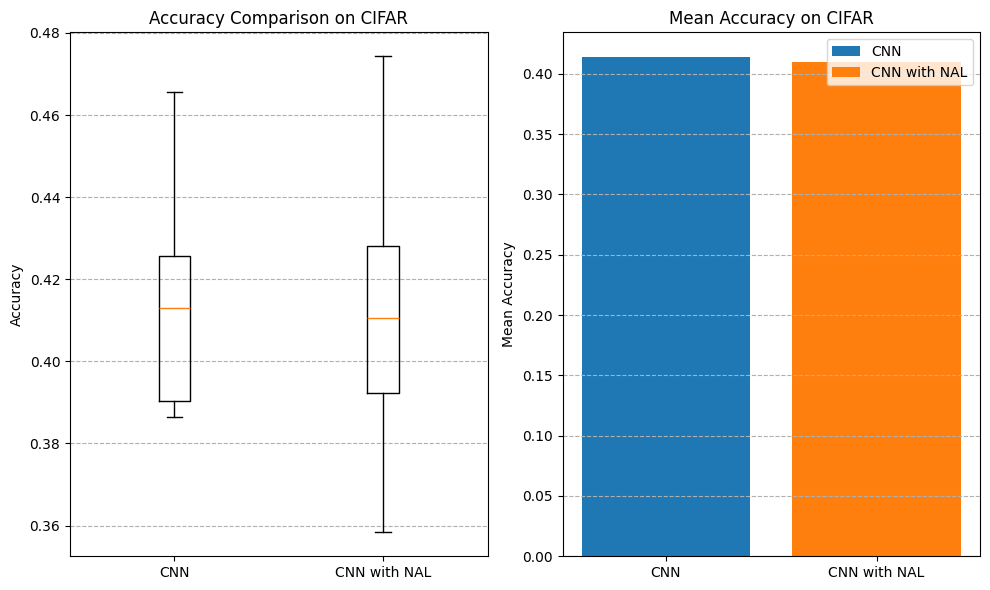

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

with open('results/cnn_CIFAR_acc_results.pkl', 'rb') as f:
    cnn_acc_CIFAR = pickle.load(f)

with open('results/cnnwithnal_CIFAR_acc_results.pkl', 'rb') as f:
    cnnwithnal_acc_CIFAR = pickle.load(f)

models   = ['CNN', "CNN with NAL"]

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].boxplot([cnn_acc_CIFAR, cnnwithnal_acc_CIFAR], labels=models)
axs[0].set_title('Accuracy Comparison on CIFAR')
axs[0].set_ylabel('Accuracy')
axs[0].grid(axis='y', linestyle='--')
axs[1].bar(models, [np.mean(cnn_acc_CIFAR), np.mean(cnnwithnal_acc_CIFAR)], label=models, color=['tab:blue', 'tab:orange'])
axs[1].set_title('Mean Accuracy on CIFAR')
axs[1].set_ylabel('Mean Accuracy')
axs[1].grid(axis='y', linestyle='--')
plt.legend(models)
plt.tight_layout()
plt.show()


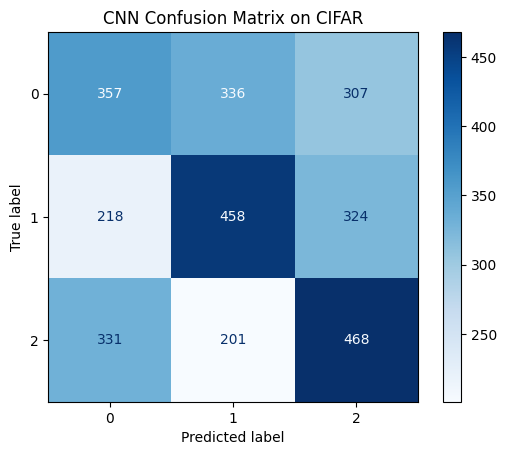

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
with open('results/cnn_CIFAR_pred_results.pkl', 'rb') as f:
    cnn_pred_results_CIFAR = pickle.load(f)
y_true = cnn_pred_results_CIFAR[0][0]
y_pred = cnn_pred_results_CIFAR[0][1]
cm = confusion_matrix(y_true, y_pred)
confusion_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
confusion_disp.plot(cmap=plt.cm.Blues)
plt.title('CNN Confusion Matrix on CIFAR')
plt.show()